In [1]:

import tensorflow as tf
import matplotlib.image as img
%matplotlib inline
import numpy as np
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow import keras
from tensorflow.keras import models
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import applications, optimizers
from tensorflow.keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16,preprocess_input
from tensorboard.plugins.hparams import api as hp
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

np.set_printoptions(precision=3, suppress=True)

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Extract the Data

In [5]:
def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    !tar xzvf food-101.tar.gz
    print("Extraction done!")

Dataset downloaded!
Extracting data..


'wget' is not recognized as an internal or external command,
operable program or batch file.


Extraction done!


tar: Error opening archive: Failed to open 'food-101.tar.gz'


Verify that the images are labeled

In [7]:
path = './food-101/images'
os.listdir(path)

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

Check the metadata of the dataset

In [8]:
os.listdir("./food-101/meta")

['classes.txt',
 'labels.txt',
 'test.json',
 'test.txt',
 'train.json',
 'train.txt']

Use a helper function provided from kaggle in the case that smaller subsets could be used to train and test.

In [9]:
# Helper method to split dataset into train and test folders
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

In [10]:
print("Creating train data...")
prepare_data('./food-101/meta/train.txt', './food-101/images', 'train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [11]:
print("Creating test data...")
prepare_data('./food-101/meta/test.txt', './food-101/images', 'test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [12]:

# Helper method to create train_mini and test_mini data samples
def dataset_mini(food_list, src, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    print("Copying images into",food_item)
    copytree(os.path.join(src,food_item), os.path.join(dest,food_item))


In [43]:
# picking food items and generating separate data folders for the same
# food_list = ['apple_pie','chicken_quesadilla','chicken_wings', 'chocolate_cake', 'cup_cakes', 'donuts', 'french_fries', 'hamburger', 'hot_dog','ice_cream', 'macaroni_and_cheese', 'pancakes', 'pizza', 'pork_chop', 'ramen', 'red_velvet_cake', 'steak', 'tacos', 'waffles', 'omelette']
# food_list = ['apple_pie', 'chocolate_cake', 'cup_cakes', 'donuts', 'french_fries', 'hamburger', 'hot_dog','ice_cream']
food_list = ['apple_pie', 'chocolate_cake', 'cup_cakes']
dest_train = 'train_mini'
src_test = 'test'
dest_test = 'test_mini'

In [44]:
print("Creating train data folder with new classes")
dataset_mini(food_list, src_train, dest_train)

Creating train data folder with new classes
Copying images into apple_pie
Copying images into chocolate_cake
Copying images into cup_cakes


In [45]:
print("Creating test data folder with new classes")
dataset_mini(food_list, src_test, dest_test)

Creating test data folder with new classes
Copying images into apple_pie
Copying images into chocolate_cake
Copying images into cup_cakes


Make sure that all images are resized so that all images are accepted as input to the model.

Use tensorflow method to split the images into train and validation images in a 80/20 split.

In [51]:
image_size = (299, 299)
batch_size = 64

train_images, val_images = tf.keras.utils.image_dataset_from_directory(
    "train_mini",
    validation_split=0.2,
    subset="both",
    seed=2762,
    image_size=image_size,
    batch_size=batch_size,
)

Found 2250 files belonging to 3 classes.
Using 1800 files for training.
Using 450 files for validation.


Check that all images are resized and show relevant photos.

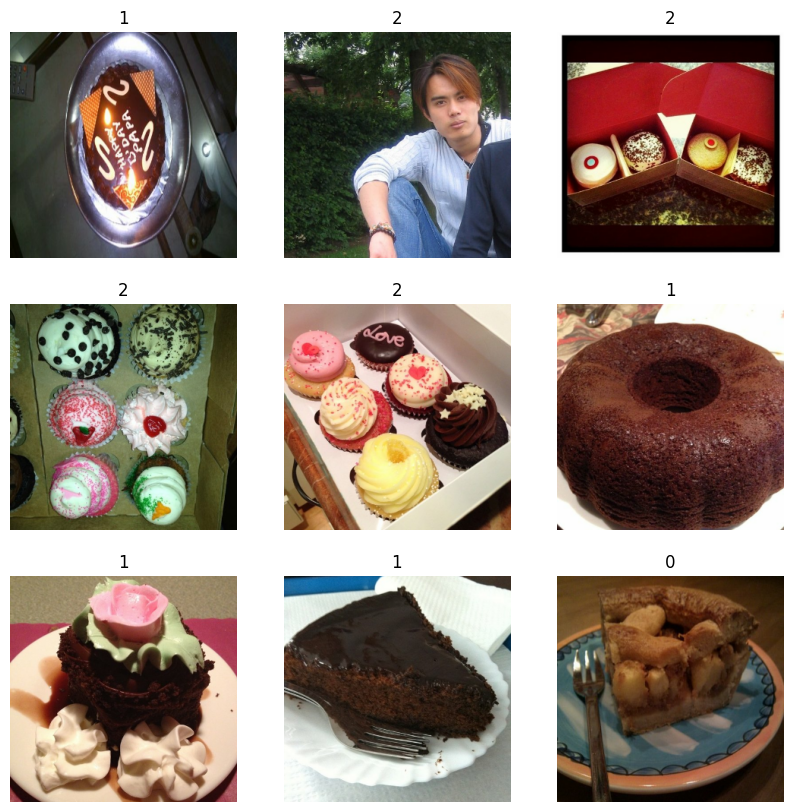

In [52]:
plt.figure(figsize=(10, 10))
for images, label in train_images.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(label[i]))
        plt.axis("off")

Create a data augmentation that will slightly flip, rotate, and zoom images to vary the images, hopefully leading to higher accuracy.

In [53]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip("horizontal_and_vertical"),
        keras.layers.RandomRotation(0.3),
        keras.layers.RandomZoom(0.5,0.2),
        keras.layers.RandomContrast(.2)
        
    ]
)

Verify that the data augmentation is working as intended.

Inspect the preproccessed image to see what is being used as the major identifier.

(-0.5, 298.5, 298.5, -0.5)

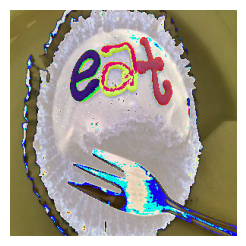

In [55]:
plt.figure(figsize=(10, 10))
vgg_ready_inputs = tf.keras.applications.vgg16.preprocess_input(images,data_format='channels_last')        
ax = plt.subplot(3, 3, i + 1)
plt.imshow(vgg_ready_inputs[1].numpy().astype("uint8"))
plt.axis("off")

Begin construction of the first base model, using the built in VGG from tensorflow. VGG is a CNN that is 16 layers deep. 

Additionally, following the VGG16, we add an aditional layer of 256 nodes, followed by dropout. We then get our prediction based on number of classes.

In [56]:
def make_multiclass_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    
    vgg_ready_inputs = tf.keras.applications.vgg16.preprocess_input(x)
    x = keras.layers.Rescaling(1.0 / 255)(vgg_ready_inputs)
    
    vgg16 = VGG16(weights='imagenet', include_top=False, input_tensor = inputs)
    vgg16.trainable = False

    x = keras.layers.Dense(16, activation='relu')(vgg16.output)
    top_dropout_rate = 0.2
    x = keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    x = keras.layers.Flatten()(x)
    prediction = keras.layers.Dense(num_classes, activation='softmax')(x)
    return keras.Model(inputs, prediction)

Ensure that the model successfully builds based on our above construction.

In [58]:
model = make_multiclass_model(input_shape=(299,299,3), num_classes=3)

Inspect the models features.

In [59]:
model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 299, 299, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 299, 299, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 299, 299, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 149, 149, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 149, 149, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 149, 149, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 74, 74, 128)       0   

Train the model. (Does not error when running, however with the GPU currently not being detected, hold off on the first training, as it will take roughly 1:30 hour for each epoch.)

In [60]:
opt = SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt,
              metrics=['sparse_categorical_accuracy'])
history=model.fit(train_images, validation_data=val_images,
                  epochs=50, batch_size=32)

Epoch 1/50


29/29 [==============================] - 10s 337ms/step - loss: 115.8929 - sparse_categorical_accuracy: 0.3311 - val_loss: 1.1150 - val_sparse_categorical_accuracy: 0.3156
Epoch 2/50
29/29 [==============================] - 7s 234ms/step - loss: 1.1002 - sparse_categorical_accuracy: 0.3311 - val_loss: 1.1009 - val_sparse_categorical_accuracy: 0.3089
Epoch 3/50
29/29 [==============================] - 7s 234ms/step - loss: 1.0981 - sparse_categorical_accuracy: 0.3356 - val_loss: 1.1120 - val_sparse_categorical_accuracy: 0.3089
Epoch 4/50
29/29 [==============================] - 7s 238ms/step - loss: 1.0997 - sparse_categorical_accuracy: 0.3450 - val_loss: 1.1027 - val_sparse_categorical_accuracy: 0.3156
Epoch 5/50
29/29 [==============================] - 7s 237ms/step - loss: 1.0986 - sparse_categorical_accuracy: 0.3300 - val_loss: 1.0988 - val_sparse_categorical_accuracy: 0.3156
Epoch 6/50
29/29 [==============================] - 7s 240ms/step - loss: 1.0988 - sparse_categorical_accura

KeyboardInterrupt: 

In [65]:
n_classes = 3
img_width, img_height = 299, 299
train_data_dir = 'train_mini'
validation_data_dir = 'test_mini'
nb_train_samples = 2250 #75750
nb_validation_samples = 750 #25250
batch_size = 16

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


Found 2250 images belonging to 3 classes.
Found 750 images belonging to 3 classes.


In [63]:
inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class.log')

history = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

Epoch 1/30
140/140 [==============================] - ETA: 0s - loss: 0.9880 - accuracy: 0.5501
Epoch 1: val_loss improved from inf to 0.72826, saving model to best_model_3class.hdf5
140/140 [==============================] - 42s 260ms/step - loss: 0.9880 - accuracy: 0.5501 - val_loss: 0.7283 - val_accuracy: 0.7758
Epoch 2/30
140/140 [==============================] - ETA: 0s - loss: 0.6892 - accuracy: 0.7654
Epoch 2: val_loss improved from 0.72826 to 0.51909, saving model to best_model_3class.hdf5
140/140 [==============================] - 32s 228ms/step - loss: 0.6892 - accuracy: 0.7654 - val_loss: 0.5191 - val_accuracy: 0.8628
Epoch 3/30
140/140 [==============================] - ETA: 0s - loss: 0.5510 - accuracy: 0.8120
Epoch 3: val_loss improved from 0.51909 to 0.41313, saving model to best_model_3class.hdf5
140/140 [==============================] - 32s 227ms/step - loss: 0.5510 - accuracy: 0.8120 - val_loss: 0.4131 - val_accuracy: 0.8872
Epoch 4/30
140/140 [=====================

In [69]:
vgg = VGG16(weights='imagenet', include_top=False)
x = vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(3,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_vgg16_model_3class.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history_3class_vgg16.log')

history = model.fit(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=30,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

Epoch 1/30
140/140 [==============================] - ETA: 0s - loss: 1.0436 - accuracy: 0.4727
Epoch 1: val_loss improved from inf to 0.78652, saving model to best_vgg16_model_3class.hdf5
140/140 [==============================] - 41s 284ms/step - loss: 1.0436 - accuracy: 0.4727 - val_loss: 0.7865 - val_accuracy: 0.7024
Epoch 2/30
140/140 [==============================] - ETA: 0s - loss: 0.7562 - accuracy: 0.6907
Epoch 2: val_loss improved from 0.78652 to 0.68445, saving model to best_vgg16_model_3class.hdf5
140/140 [==============================] - 32s 225ms/step - loss: 0.7562 - accuracy: 0.6907 - val_loss: 0.6844 - val_accuracy: 0.7065
Epoch 3/30
140/140 [==============================] - ETA: 0s - loss: 0.6097 - accuracy: 0.7766
Epoch 3: val_loss improved from 0.68445 to 0.42757, saving model to best_vgg16_model_3class.hdf5
140/140 [==============================] - 32s 225ms/step - loss: 0.6097 - accuracy: 0.7766 - val_loss: 0.4276 - val_accuracy: 0.8560
Epoch 4/30
140/140 [===